# SVM Analysis
Kiron Ang

---

This analysis uses the Python programming language and a Google Colab hosted runtime. The popular libraries *scikit-learn*, *seaborn*, and *pandas* are also used.



In [ ]:
!python -V

!pip install -U scikit-learn > output.txt
import sklearn
print("scikit-learn", sklearn.__version__)

!pip install -U seaborn > output.txt
import seaborn
print("seaborn", seaborn.__version__)

import pandas
print("pandas", pandas.__version__)

Python 3.10.12
scikit-learn 1.5.2
seaborn 0.13.2
pandas 2.1.4


The data for this analysis comes from the "Superintendent Salary Report by District for School Year 2023-2024"; this is a public dataset released by the Texas Education Agency, and is available online: https://data.texas.gov/dataset/Superintendent-Salary-Report-by-District-for-Schoo/6dh5-cse4.

In [ ]:
data = pandas.read_json("https://data.texas.gov/resource/6dh5-cse4.json")
data

,state,region,county,district,district_name,charter_status,superintendent,base_pay,fte_pay,enrollment,fte
0,TX,10,DALLAS COUNTY,57816,A W BROWN LEADERSHIP ACADEMY,OPEN ENROLLMENT CHARTER,"CAGER, SHENIKWA M",111720,111720.0,778,1.0
1,TX,10,DALLAS COUNTY,57829,A+ ACADEMY,OPEN ENROLLMENT CHARTER,"WHITE, BRENTON P",122020,244040.0,1649,0.5
2,TX,4,HARRIS COUNTY,101871,A+ UNLIMITED POTENTIAL,OPEN ENROLLMENT CHARTER,"CASTRO, PAUL DAVID",165468,165468.0,150,1.0
3,TX,12,HILL COUNTY,109901,ABBOTT ISD,TRADITIONAL ISD/CSD,"PUSTEJOVSKY, ERIC D",116133,116133.0,284,1.0
4,TX,17,HALE COUNTY,95901,ABERNATHY ISD,TRADITIONAL ISD/CSD,"WALDRIP, AARON MARK",140190,140190.0,812,1.0
...,...,...,...,...,...,...,...,...,...,...,...
995,TX,14,COMANCHE COUNTY,47905,SIDNEY ISD,TRADITIONAL ISD/CSD,"RUCKER, JAMES EDWIN",45000,90000.0,152,0.5
996,TX,19,HUDSPETH COUNTY,115902,SIERRA BLANCA ISD,TRADITIONAL ISD/CSD,"MCGRAW, R LEEANN",100680,100680.0,99,1.0
997,TX,5,HARDIN COUNTY,100904,SILSBEE ISD,TRADITIONAL ISD/CSD,"WEISS, GREGORY WAYNE",177124,177124.0,2654,1.0
998,TX,16,BRISCOE COUNTY,23902,SILVERTON ISD,TRADITIONAL ISD/CSD,"FRANCIS, MICHELLE R",96658,96658.0,223,1.0


The present work compares the performance of three Support Vector Machine algorithms implemented as classes in *scikit-learn*: SVC, NuSVC, and LinearSVC. Binary classification is performed with "charter_status" serving as the labels and "base_pay" and "enrollment" serving as input features. The goal of this analysis is to understand what kinds of patterns are seen between superintendents' salaries and the enrollment at their school districts, both at independent school districts and at open enrollment charter school districts.

First, a scatterplot of the the two input features is generated to understand the distribution of the labeled data.

<Axes: xlabel='enrollment', ylabel='base_pay'>

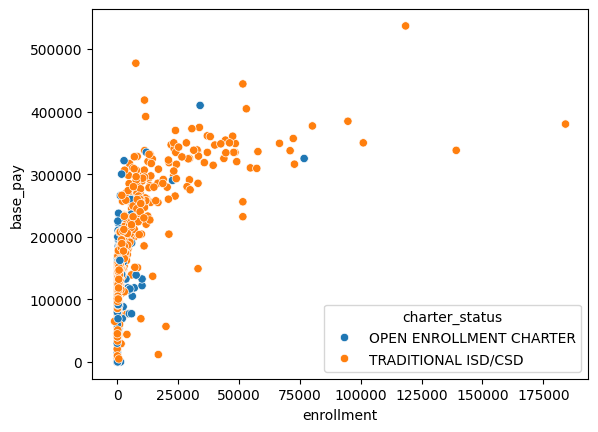

In [ ]:
seaborn.scatterplot(data=data, x="enrollment", y="base_pay", hue="charter_status")

Each dot on the plot above represents a superintendent in Texas. Interpreting this scatter plot requires information from the dataset's website:

* **"charter_status"** identifies whether the district is an independent school district or an open enrollment charter school district. This is in reference to the school district that each superintendent belongs to.
* **"base_pay"** reports each superintendent's total payroll amount for the year.
* **"enrollment"** indicates the total enrollment for the superintendent's school district.

It appears that "base_pay" may experience logarithmic growth in relation to "enrollment". However, it is clear that most of the 1,000 data points are clustered in one group, and data points from both groups are interspersed throughout. Using Support Vector Machine algorithms may be able to parse out these differences to accurately predict "charter_status". According to the *scikit-learn* user guide, available at https://scikit-learn.org/stable/modules/svm.html, it is recommended to implement these algorithms with a *scikit-learn* pipeline.



In [ ]:
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.svm

pipeline = sklearn.pipeline.make_pipeline(
                sklearn.preprocessing.RobustScaler(),
                sklearn.svm.SVC()
            )
pipeline

Pipeline(steps=[('robustscaler', RobustScaler()), ('svc', SVC())])

The pipeline above first scales the data using *scikit-learn*'s RobustScaler and then applies the SVC class, one of the Support Vector Machine classifiers availble. Before feeding data into the pipeline, the dataset must be split into two parts: one for training the model, and the other for testing the model's accuracy.

In [ ]:
import sklearn.model_selection

X = data[["base_pay", "enrollment"]]
y = data["charter_status"]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

print("Number of rows in X_train:", len(X_train))
print("Number of rows in X_test:", len(X_test))
print("Number of rows in y_train:", len(y_train))
print("Number of rows in y_test:", len(y_test))

Number of rows in X_train: 750
Number of rows in X_test: 250
Number of rows in y_train: 750
Number of rows in y_test: 250


Now the pipeline can be used to fit an SVC model and obtain scores for accuracy, precision, and recall.

In [ ]:
import sklearn.metrics

pipeline.fit(X_train, y_train)

y_predict = pipeline.predict(X_test)

accuracy = sklearn.metrics.accuracy_score(y_test, y_predict)
precision = sklearn.metrics.precision_score(y_test, y_predict, pos_label="TRADITIONAL ISD/CSD")
recall = sklearn.metrics.recall_score(y_test, y_predict, pos_label="TRADITIONAL ISD/CSD")

print("Accuracy/Precision/Recall:", accuracy, precision, recall)

Accuracy/Precision/Recall: 0.86 0.86 1.0


Although the accuracy indicates some degree of predictive effectiveness at 86%, the accuracy and precision scores are the same, suggesting the dataset is imbalanced or the model is overfitting. Furthermore, a recall score of 1.0 implies that all "positive" cases were correctly identified. Here, "positive" cases represented superintendents that belonged to "TRADITIONAL ISD/CSD". Therefore, the lack of accuracy was due to an inability to correctly predict "OPEN ENROLLMENT CHARTER" superintendents. Generating a scatter plot and a confusion matrix of the testing data may help with understanding this situation.

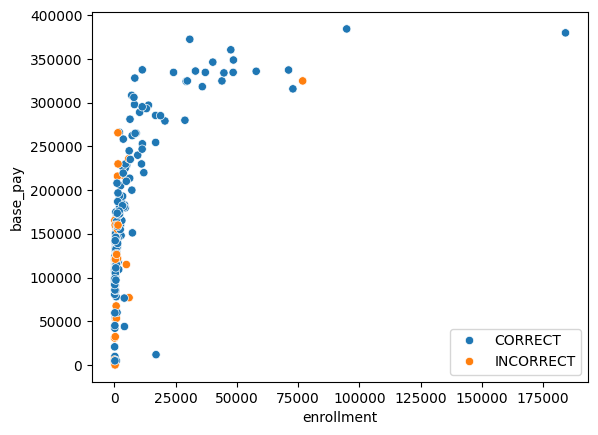

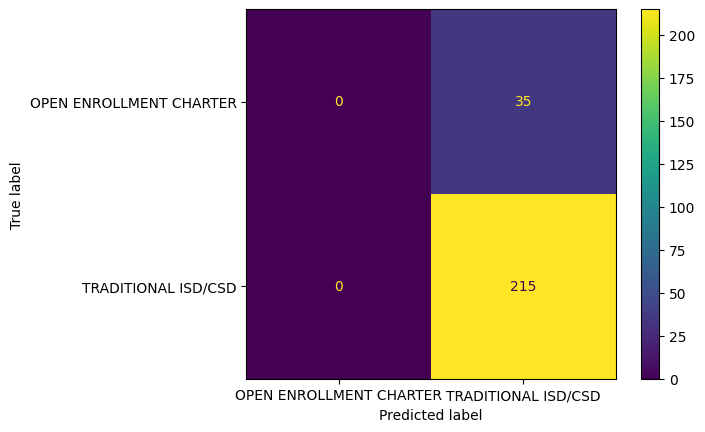

In [ ]:
predictions = []
number = 0
for test in y_test:
  if y_predict[number] == test:
    predictions.append("CORRECT")
  else:
    predictions.append("INCORRECT")
  number += 1

seaborn.scatterplot(x=X_test["enrollment"], y=X_test["base_pay"], hue=predictions)

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_predict)

In the scatter plot above, the blue dots represent data points in the testing data that the model predicted correctly, while orange dots represent incorrect predictions. The confusion matrix illustrates that the model simply guessed that all of the data points in the testing data were from "TRADITIONAL ISD/CSD", even though 35 of those data points were truly  from "OPEN ENROLLMENT CHARTER" districts. The scatter plot shows that the confusion was likely due to the fact that the "OPEN ENROLLMENT CHARTER" data points are mixed thoroughly with the  "TRADITIONAL ISD/CSD" values, and without any other features to distinguish them, the imbalanced dataset causes a large shortcoming of the model. Creating new pipelines with the other two SVM classification classes, NuSVC and LinearSVC, may improve upon these results. The NuSVC classifier is used below.

Accuracy/Precision/Recall: 0.736 0.8941798941798942 0.786046511627907


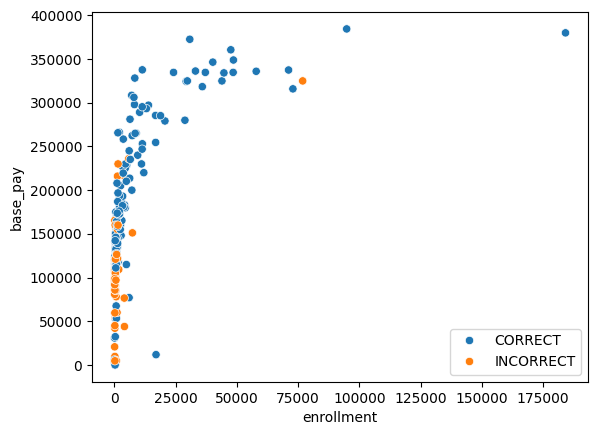

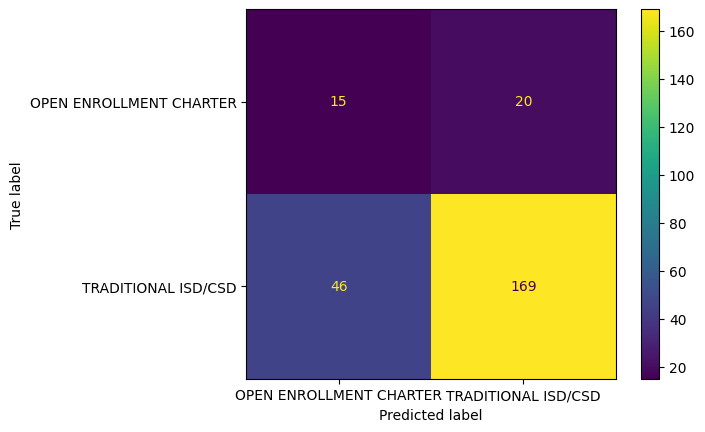

In [ ]:
pipeline = sklearn.pipeline.make_pipeline(
                sklearn.preprocessing.RobustScaler(),
                # Ensure nu is small enough to avoid the error:
                # ValueError: specified nu is infeasible
                sklearn.svm.NuSVC(nu=0.2)
            )

pipeline.fit(X_train, y_train)

y_predict = pipeline.predict(X_test)

accuracy = sklearn.metrics.accuracy_score(y_test, y_predict)
precision = sklearn.metrics.precision_score(y_test, y_predict, pos_label="TRADITIONAL ISD/CSD")
recall = sklearn.metrics.recall_score(y_test, y_predict, pos_label="TRADITIONAL ISD/CSD")

print("Accuracy/Precision/Recall:", accuracy, precision, recall)

predictions = []
number = 0
for test in y_test:
  if y_predict[number] == test:
    predictions.append("CORRECT")
  else:
    predictions.append("INCORRECT")
  number += 1

seaborn.scatterplot(x=X_test["enrollment"], y=X_test["base_pay"], hue=predictions)

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_predict)

The accuracy is lower with Nu-Support Vector Classification compared to the previous Support Vector Classification, but the precision has improved. The scatter plot demonstrates the intrinsic difficulty of the data set yet again, while the confusion matrix shows that this time, some of the predictions consist of "OPEN ENROLLMENT CHARTER". The final classifier is LinearSVC, and this is demonstrated below:

Accuracy/Precision/Recall: 0.86 0.86 1.0


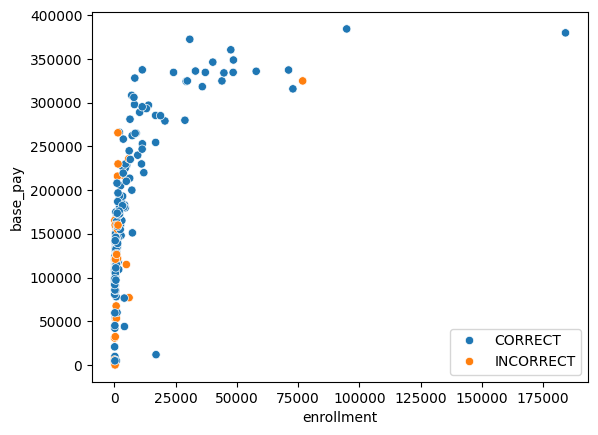

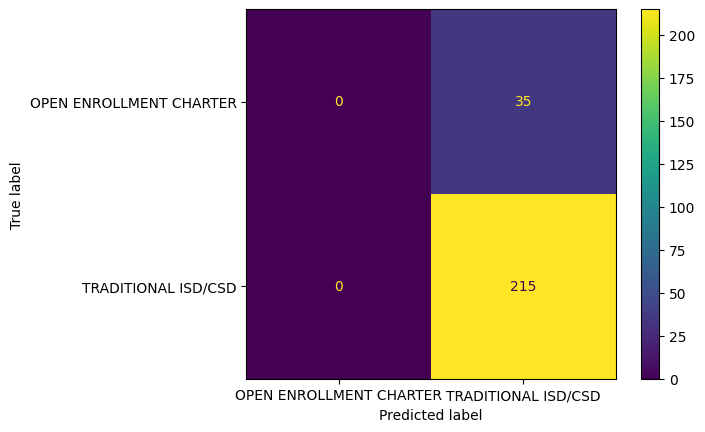

In [ ]:
pipeline = sklearn.pipeline.make_pipeline(
                sklearn.preprocessing.RobustScaler(),
                # Ensure nu is small enough to avoid the error:
                # ValueError: specified nu is infeasible
                sklearn.svm.LinearSVC()
            )

pipeline.fit(X_train, y_train)

y_predict = pipeline.predict(X_test)

accuracy = sklearn.metrics.accuracy_score(y_test, y_predict)
precision = sklearn.metrics.precision_score(y_test, y_predict, pos_label="TRADITIONAL ISD/CSD")
recall = sklearn.metrics.recall_score(y_test, y_predict, pos_label="TRADITIONAL ISD/CSD")

print("Accuracy/Precision/Recall:", accuracy, precision, recall)

predictions = []
number = 0
for test in y_test:
  if y_predict[number] == test:
    predictions.append("CORRECT")
  else:
    predictions.append("INCORRECT")
  number += 1

seaborn.scatterplot(x=X_test["enrollment"], y=X_test["base_pay"], hue=predictions)

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_predict)

The LinearSVC class runs into the same exact problem as the previous SVC class. Although parameter tuning with cross validation may resolve some of the problems observed in this analysis, the NuSVC was able to achieve some form of success in an imbalanced dataset with only two input features. The performance of Support Vector Machine algorithms relative to other algorithms is higher with higher-dimension datasets, and so future work can incorporate more data on superintendents and school districts. Currently, it is unclear what patterns are present aside from those seen in the scatter plot, but this is due to how the SVM classifiers are not well-suited for this data.